### This notebook looks at the impact of systematically deleting SC ... to the OUTER networks i.e., from ntwx A to ntwx B, C, etc

### This is for task fMRI - MOTOR

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [2]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [3]:
from collections import Counter

In [4]:
import seaborn as sns
import scipy.stats as stats

In [5]:
import pickle

In [6]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [7]:
import re

In [8]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [9]:
sub_list.index(140420) # the task fMRI dtseries for this subject is absent in the HCP S-900 folder in public datasets. 

133

In [10]:
# del sub_list[133]

In [11]:
node_size = 200
mask = np.tril_indices(node_size, -1)

#### empirical task fMRI data

In [12]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_IV/'

In [13]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_tfMRI_MOTOR_RL_200Schaefer_7Ntwx_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [14]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.2 s, sys: 365 ms, total: 59.6 s
Wall time: 1min 3s


In [15]:
%%time
all_subs_emp_fc_mat = []
for i in range(199):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 450 ms, sys: 37.2 ms, total: 487 ms
Wall time: 485 ms


#### empirical rest fMRI data

In [16]:
pconn_path2 = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [17]:
def rest_emp_fc(sub_id):
    pconn1LR = pconn_path2 + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [18]:
%%time

all_subs_rest_emp_fc = []
for i in range(len(sub_list)):
    ss_rest_emp_fc = rest_emp_fc(sub_list[i])
    all_subs_rest_emp_fc.append(ss_rest_emp_fc)

CPU times: user 59.8 s, sys: 539 ms, total: 1min
Wall time: 1min 2s


In [19]:
%%time
all_subs_rest_emp_fc_mat = []
for i in range(199):
    all_subs_rest_emp_fc_mat.append(np.corrcoef(all_subs_rest_emp_fc[i].T))

CPU times: user 1.37 s, sys: 72.2 ms, total: 1.45 s
Wall time: 1.44 s


In [20]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_task_run_pkls_III_conn_mats_only'

In [21]:
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_TASK_WhoBPyT_motor_model_params_pkls'

In [22]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_smt_lesion = []
all_subs_dan_lesion = []
all_subs_van_lesion = []
all_subs_lim_lesion = []
all_subs_fpn_lesion = []
all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/motor_task_og_whobpyt_Subj_{0}_con_mat.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    
    ss_smt_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_dan_lesion.append(ss_dan_lesion)
    
    ss_van_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_van_lesion.append(ss_van_lesion)
    
    ss_lim_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_lim_lesion.append(ss_lim_lesion)
    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_motor_task_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)


CPU times: user 1min 31s, sys: 2.3 s, total: 1min 33s
Wall time: 2min 1s


In [23]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_smt_lesion,
                        all_subs_dan_lesion,all_subs_van_lesion,
                        all_subs_lim_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

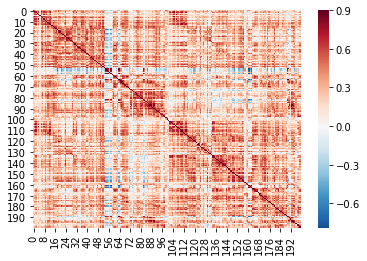

In [30]:
sns.heatmap(all_subs_emp_fc_mat[24], cmap='RdBu_r',center=0,vmax=0.9)

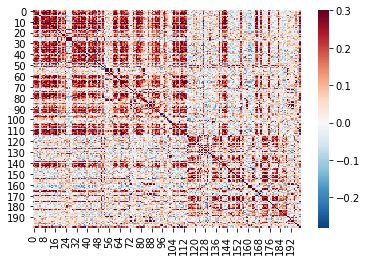

In [32]:
sns.heatmap(all_subs_og_whobpyt[24], cmap='RdBu_r',center=0,vmax=0.3)

In [33]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [34]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### divide by 2

In [35]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)
    mean_ntwx_to_sommot_fc = ((np.mean(lh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/2 + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2)
    mean_ntwx_to_dorsattn_fc = ((np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/2 + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2)
    mean_ntwx_to_ventattn_fc = ((np.mean(lh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/2 + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2)
    mean_ntwx_to_limbic_fc = ((np.mean(lh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/2 + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2)
    mean_ntwx_to_fpn_fc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)
    mean_ntwx_to_dmn_fc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    


### empirical data

In [37]:
%%time

empirical_vis_to_other_ntwx = []
empirical_sommot_to_other_ntwx = []
empirical_dorsattn_to_other_ntwx = []
empirical_ventattn_to_other_ntwx = []
empirical_limbic_to_other_ntwx = []
empirical_fpn_to_other_ntwx = []
empirical_dmn_to_other_ntwx = []

for i in range(199):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,0)
    empirical_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,1)
    empirical_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,2)
    empirical_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,3)
    empirical_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,4)
    empirical_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,5)
    empirical_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,6)
    empirical_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 763 ms, sys: 3.93 ms, total: 767 ms
Wall time: 766 ms


In [38]:
empirical_vis_to_other_ntwx = np.mean(empirical_vis_to_other_ntwx,axis=0)
empirical_sommot_to_other_ntwx = np.mean(empirical_sommot_to_other_ntwx,axis=0)
empirical_dorsattn_to_other_ntwx = np.mean(empirical_dorsattn_to_other_ntwx,axis=0)
empirical_ventattn_to_other_ntwx = np.mean(empirical_ventattn_to_other_ntwx,axis=0)
empirical_limbic_to_other_ntwx = np.mean(empirical_limbic_to_other_ntwx,axis=0)
empirical_fpn_to_other_ntwx = np.mean(empirical_fpn_to_other_ntwx,axis=0)
empirical_dmn_to_other_ntwx = np.mean(empirical_dmn_to_other_ntwx,axis=0)

In [39]:
# Across all 200 subs
empirical_outer_to_other_ntwx  = [empirical_vis_to_other_ntwx,empirical_sommot_to_other_ntwx,
                                   empirical_dorsattn_to_other_ntwx,empirical_ventattn_to_other_ntwx,
                                   empirical_limbic_to_other_ntwx,empirical_fpn_to_other_ntwx,
                                   empirical_dmn_to_other_ntwx]

### original WhoBPyT

In [40]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(199):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 771 ms, sys: 33.1 ms, total: 804 ms
Wall time: 801 ms


In [41]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [42]:
og_whobpyt_vis_to_other_ntwx_std = np.std(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx_std = np.std(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx_std = np.std(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx_std = np.std(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx_std = np.std(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx_std = np.std(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx_std = np.std(all_subs_dmn_to_other_ntwx,axis=0)

In [43]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [44]:
og_whobpyt_outer_to_other_ntwx_std = [og_whobpyt_vis_to_other_ntwx_std,og_whobpyt_sommot_to_other_ntwx_std,
                                      og_whobpyt_dorsattn_to_other_ntwx_std,og_whobpyt_ventattn_to_other_ntwx_std,
                                      og_whobpyt_limbic_to_other_ntwx_std,og_whobpyt_fpn_to_other_ntwx_std,
                                      og_whobpyt_dmn_to_other_ntwx_std]

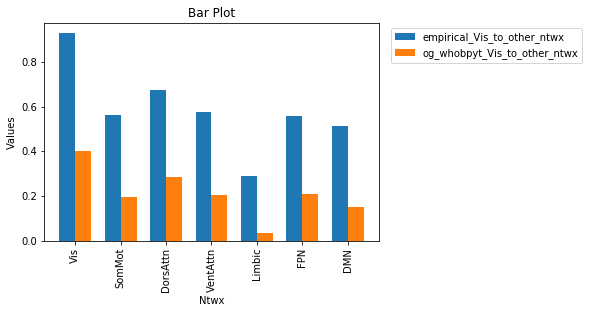

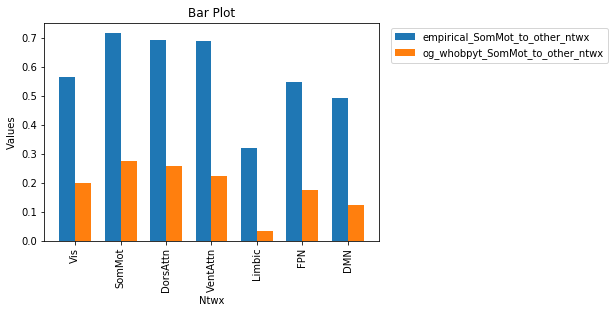

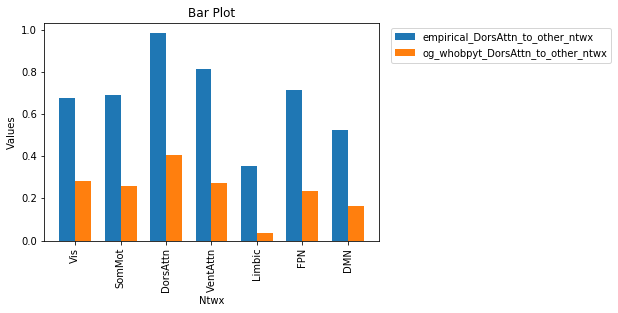

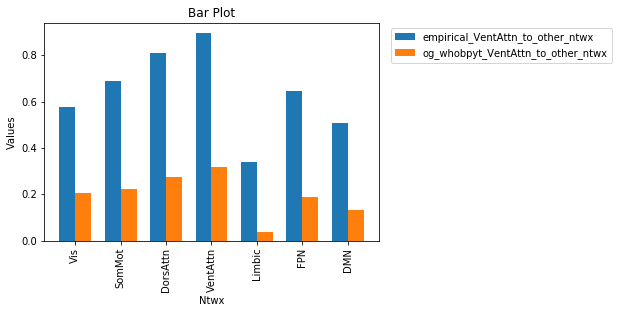

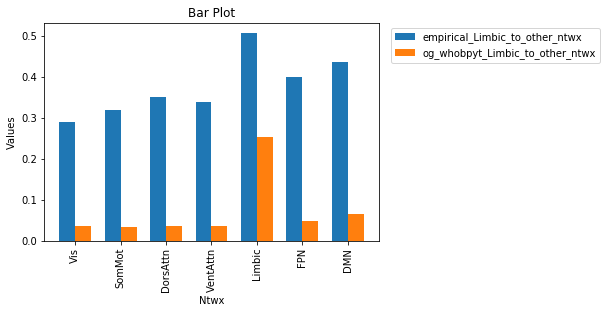

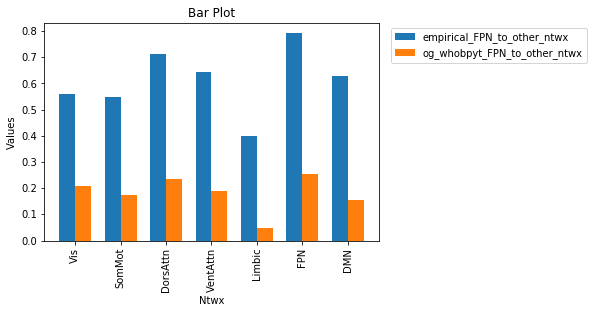

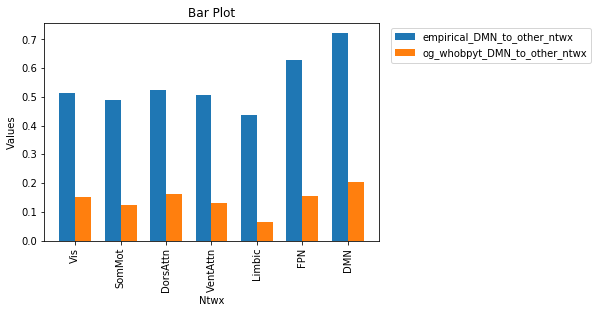

In [45]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, empirical_outer_to_other_ntwx[j], width, label='empirical_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], og_whobpyt_outer_to_other_ntwx[j], width, label='og_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    # Displaying the plot
    plt.show()

### Lesion WhoBPyT

In [48]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(199):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [49]:
def get_outer_ntwx_fc_std(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(199):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    std_all_subs_vis_to_other_ntwx_lesions = np.std(all_subs_vis_to_other_ntwx_lesions,axis=0)
    std_all_subs_sommot_to_other_ntwx_lesions = np.std(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    std_all_subs_dorsattn_to_other_ntwx_lesions = np.std(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_ventattn_to_other_ntwx_lesions = np.std(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_limbic_to_other_ntwx_lesions = np.std(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    std_all_subs_fpn_to_other_ntwx_lesions = np.std(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    std_all_subs_dmn_to_other_ntwx_lesions = np.std(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return std_all_subs_vis_to_other_ntwx_lesions,std_all_subs_sommot_to_other_ntwx_lesions,std_all_subs_dorsattn_to_other_ntwx_lesions,std_all_subs_ventattn_to_other_ntwx_lesions,std_all_subs_limbic_to_other_ntwx_lesions,std_all_subs_fpn_to_other_ntwx_lesions,std_all_subs_dmn_to_other_ntwx_lesions

In [50]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(199):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [51]:
len(all_subs_vis_lesion)

199

# Mean

In [52]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_smt_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dan_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_van_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.26 s, sys: 196 ms, total: 5.45 s
Wall time: 5.43 s


In [53]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [54]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

# Standard Deviation

In [55]:
vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_vis_lesion)

sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_smt_lesion)

dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dan_lesion)

ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_van_lesion)

limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_lim_lesion)

fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_fpn_lesion)

dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dmn_lesion)

In [56]:
vis_lesion_std_outer_to_other_ntwx = [vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx]
sommot_lesion_std_outer_to_other_ntwx = [sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx]
dorsattn_lesion_std_outer_to_other_ntwx = [dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx]
ventattn_lesion_std_outer_to_other_ntwx = [ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx]
limbic_lesion_std_outer_to_other_ntwx = [limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx = [fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx = [dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx]

In [57]:
og_whobpyt_outer_to_other_ntwx_std = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx_std]


vis_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in vis_lesion_std_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in sommot_lesion_std_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dorsattn_lesion_std_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in ventattn_lesion_std_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in limbic_lesion_std_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in fpn_lesion_std_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dmn_lesion_std_outer_to_other_ntwx]

### ------------------------------------------------------------------------------------------

In [58]:
%%time

# For stats

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_smt_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dan_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_van_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_lim_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dmn_lesion)


CPU times: user 5.12 s, sys: 17 ms, total: 5.14 s
Wall time: 5.12 s


In [59]:
og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_og_whobpyt)


In [60]:
# For stats

In [61]:
og_whobpyt_all_subs_outer_to_other_ntwx = [og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_outer_to_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_outer_to_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_outer_to_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_outer_to_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_outer_to_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_outer_to_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_outer_to_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [62]:
len(vis_lesion_outer_to_other_ntwx[0])

7

In [63]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [64]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [65]:
# not means ... individual 7x7 values ...

def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
#         percent_change_ntwx = [b-a for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
       
    return percent_change_all_ntwx_lesion

In [66]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_outer_to_other_ntwx,6)

In [67]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [68]:
Ntwx_labels = ['VIS', 'SMT', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

In [69]:
percent_change_all_ntwx_all_vals[0]

[[-17.731552318035053,
  -99.19812237702352,
  -99.51478974631502,
  -99.51159751124594,
  -98.63600583338832,
  -100.25921205883701,
  -99.8018953384346],
 [-99.19812237702352,
  -7.1015659772164925,
  -13.01892976681499,
  -10.553478730287713,
  -15.998704566264275,
  -14.597778086792863,
  -15.113469887660386],
 [-99.51478974631502,
  -13.01892976681499,
  -12.448193540901366,
  -13.567130013257083,
  -23.34382145224564,
  -17.84682704772362,
  -20.11822804197146],
 [-99.51159751124594,
  -10.553478730287713,
  -13.567130013257064,
  -7.635335440228191,
  -16.031603254559176,
  -14.15780578643067,
  -15.614792416256625],
 [-98.63600583338832,
  -15.998704566264294,
  -23.34382145224564,
  -16.031603254559176,
  0.9610638632158439,
  -7.282080703957602,
  -1.8000820371860837],
 [-100.25921205883701,
  -14.597778086792863,
  -17.846827047723636,
  -14.15780578643067,
  -7.282080703957589,
  -11.00289651776627,
  -14.876864596901825],
 [-99.8018953384346,
  -15.113469887660397,
  -20.1

In [70]:
for i in range(7):
    print(Ntwx_labels[i], 'lesion')
    for j in range(7):
        print(percent_change_all_ntwx_all_vals[i][j])
        print('')
    print('------------------------------------------------------------------------')

VIS lesion
[-17.731552318035053, -99.19812237702352, -99.51478974631502, -99.51159751124594, -98.63600583338832, -100.25921205883701, -99.8018953384346]

[-99.19812237702352, -7.1015659772164925, -13.01892976681499, -10.553478730287713, -15.998704566264275, -14.597778086792863, -15.113469887660386]

[-99.51478974631502, -13.01892976681499, -12.448193540901366, -13.567130013257083, -23.34382145224564, -17.84682704772362, -20.11822804197146]

[-99.51159751124594, -10.553478730287713, -13.567130013257064, -7.635335440228191, -16.031603254559176, -14.15780578643067, -15.614792416256625]

[-98.63600583338832, -15.998704566264294, -23.34382145224564, -16.031603254559176, 0.9610638632158439, -7.282080703957602, -1.8000820371860837]

[-100.25921205883701, -14.597778086792863, -17.846827047723636, -14.15780578643067, -7.282080703957589, -11.00289651776627, -14.876864596901825]

[-99.8018953384346, -15.113469887660397, -20.11822804197146, -15.614792416256662, -1.8000820371860837, -14.87686459690

In [71]:
percent_change_all_ntwx_all_vals = np.array(percent_change_all_ntwx_all_vals)

In [72]:
import numpy.ma as ma

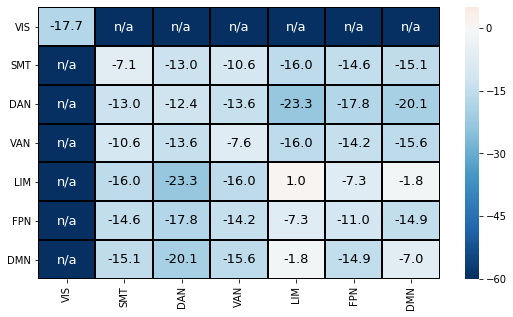

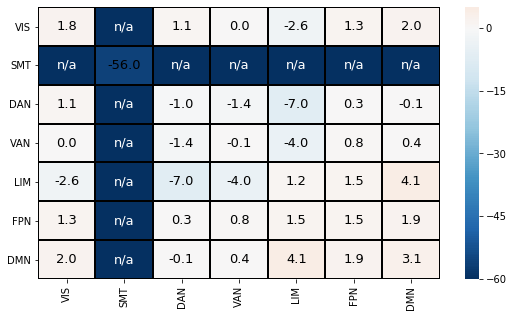

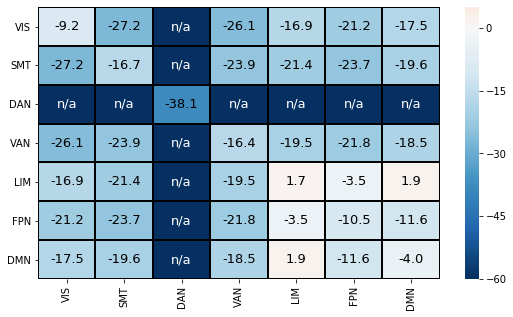

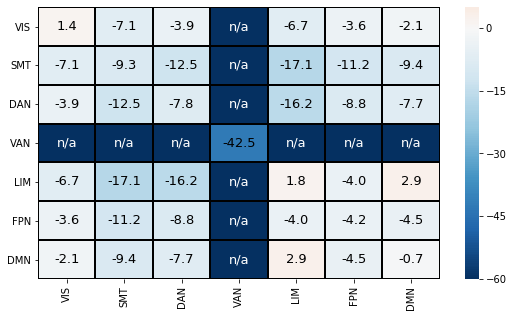

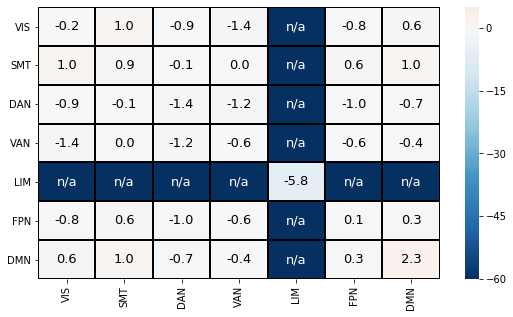

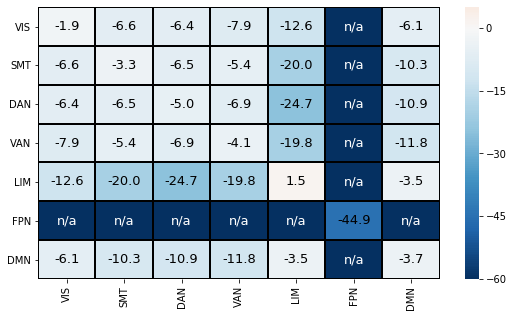

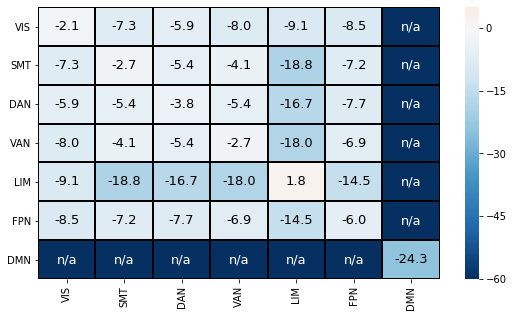

In [73]:
for i in range(7):
    fig, ax = plt.subplots(figsize=(9,5))
    
    sns.heatmap(percent_change_all_ntwx_all_vals[i,:,:],cmap='RdBu_r',center=0, vmin=-60, vmax = 5,linewidths=1, linecolor='black')
    # Annotate each cell with the corresponding value
    for x in range(len(Ntwx_labels)):
        for y in range(len(Ntwx_labels)):
            value = percent_change_all_ntwx_all_vals[i, x, y]
            if value > -90:
                ax.text(y + 0.5, x + 0.5, f'{value:.1f}', ha='center', va='center', color='black', fontsize=13)
            elif value <= -90:
                ax.text(y + 0.5, x + 0.5, 'n/a', ha='center', va='center', color='white', fontsize=13)
    ax.set_xticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_xticklabels(Ntwx_labels, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_yticklabels(Ntwx_labels, rotation=0, ha='right')
    plt.show()


In [75]:
all_ntwx_outer_to_other_ntwx = [vis_lesion_all_subs_outer_to_other_ntwx,
                                smt_lesion_all_subs_outer_to_other_ntwx,
                                dan_lesion_all_subs_outer_to_other_ntwx,
                                van_lesion_all_subs_outer_to_other_ntwx,
                                lim_lesion_all_subs_outer_to_other_ntwx,
                                fpn_lesion_all_subs_outer_to_other_ntwx,
                                dmn_lesion_all_subs_outer_to_other_ntwx]

In [76]:
# significance table

def boolean_sig_table(ntwx_idx):
    boolean_significance_table = np.zeros((7, 7))
    for i in range(7):
        condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
        condition_B = all_ntwx_outer_to_other_ntwx[ntwx_idx][i]
        
        t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
        for idx, val in enumerate(p_val):
            if val < 0.01:
                boolean_significance_table[i,idx] = 1
            elif val > 0.01:
                boolean_significance_table[i,idx] = 0
                
    return boolean_significance_table

vis_bool_sig_table = boolean_sig_table(0)
smt_bool_sig_table = boolean_sig_table(1)
dan_bool_sig_table = boolean_sig_table(2)
van_bool_sig_table = boolean_sig_table(3)
lim_bool_sig_table = boolean_sig_table(4)
fpn_bool_sig_table = boolean_sig_table(5)
dmn_bool_sig_table = boolean_sig_table(6)

In [77]:
all_ntwx_sig_tables = [vis_bool_sig_table,
smt_bool_sig_table,
dan_bool_sig_table,
van_bool_sig_table,
lim_bool_sig_table,
fpn_bool_sig_table,
dmn_bool_sig_table]

In [84]:
all_ntwx_sig_tables[2]

array([[1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1.]])

In [79]:
corrected_all_ntwx_sig_tables = []
ntwx_count = np.arange(0,7)

In [80]:
ntwx_count

array([0, 1, 2, 3, 4, 5, 6])

In [81]:
def corrected_sig_bools(ntwx_idx):
    boolean_3d_array = all_ntwx_sig_tables[ntwx_idx].copy()
    for i in range(7):
        boolean_3d_array[i][ntwx_idx] = 0 
        boolean_3d_array[ntwx_idx][i] = 0 
        
    boolean_3d_array[ntwx_idx][ntwx_idx] = 1

    return boolean_3d_array

In [82]:
corrected_vis_bool_sig_table = corrected_sig_bools(0)
corrected_smt_bool_sig_table = corrected_sig_bools(1)
corrected_dan_bool_sig_table = corrected_sig_bools(2)
corrected_van_bool_sig_table = corrected_sig_bools(3)
corrected_lim_bool_sig_table = corrected_sig_bools(4)
corrected_fpn_bool_sig_table = corrected_sig_bools(5)
corrected_dmn_bool_sig_table = corrected_sig_bools(6)

In [83]:
corrected_dan_bool_sig_table

array([[1., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1.]])

In [85]:
corrected_all_ntwx_sig_tables = [corrected_vis_bool_sig_table,
corrected_smt_bool_sig_table,
corrected_dan_bool_sig_table,
corrected_van_bool_sig_table,
corrected_lim_bool_sig_table,
corrected_fpn_bool_sig_table,
corrected_dmn_bool_sig_table]

In [86]:
annotations = np.where(corrected_all_ntwx_sig_tables[0], '*', '')
# annotations

In [89]:
import matplotlib.colors as mcolors

In [90]:
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'], N=256, gamma=1.0)


In [124]:
sns.set_style('darkgrid')

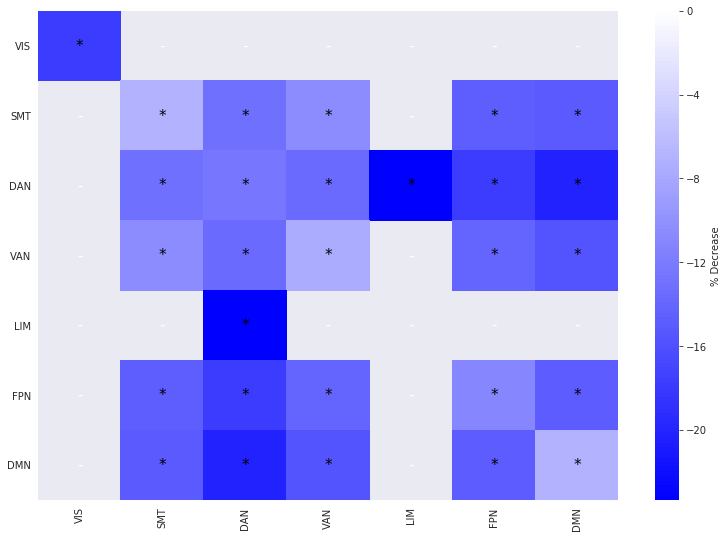

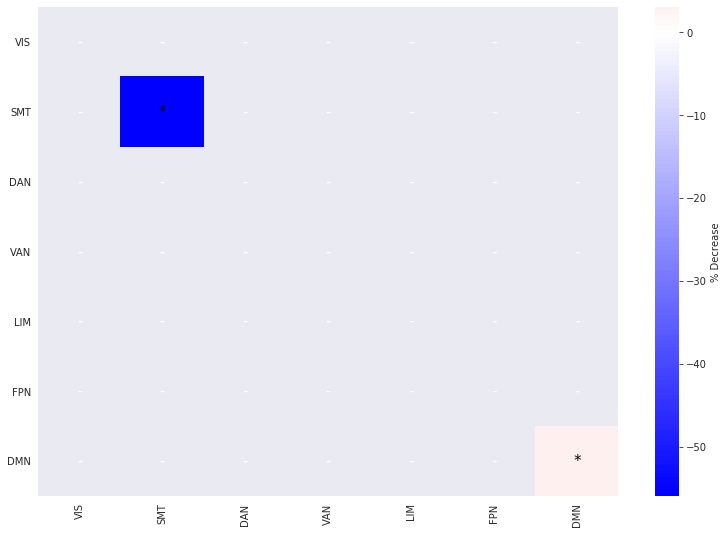

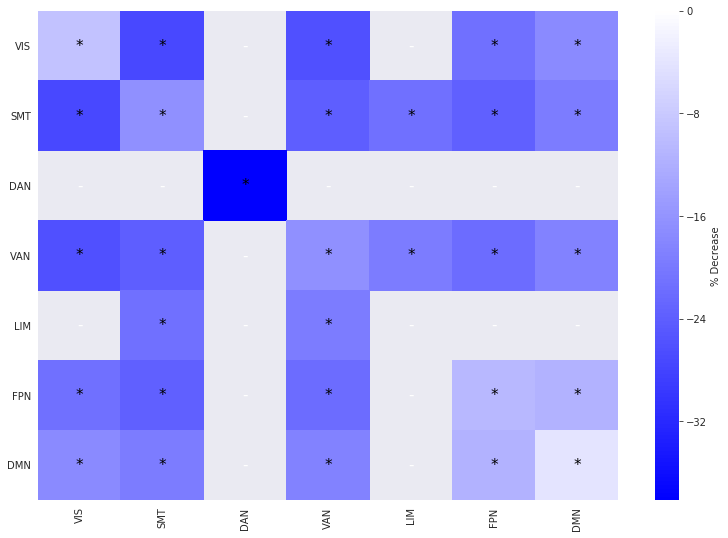

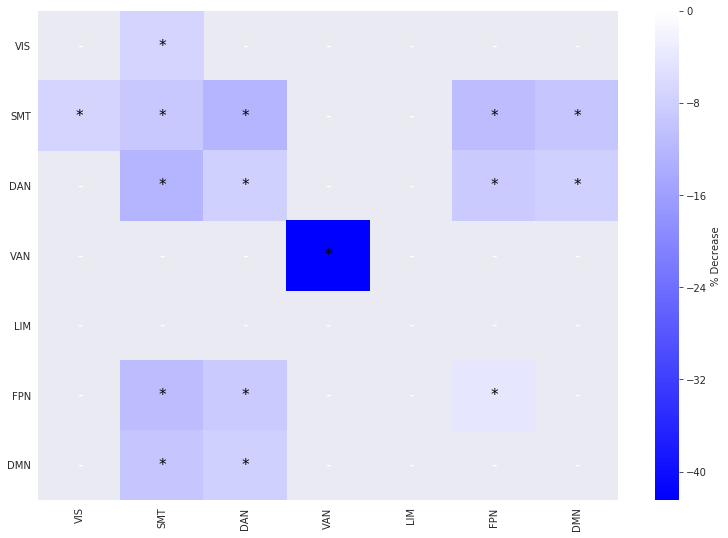

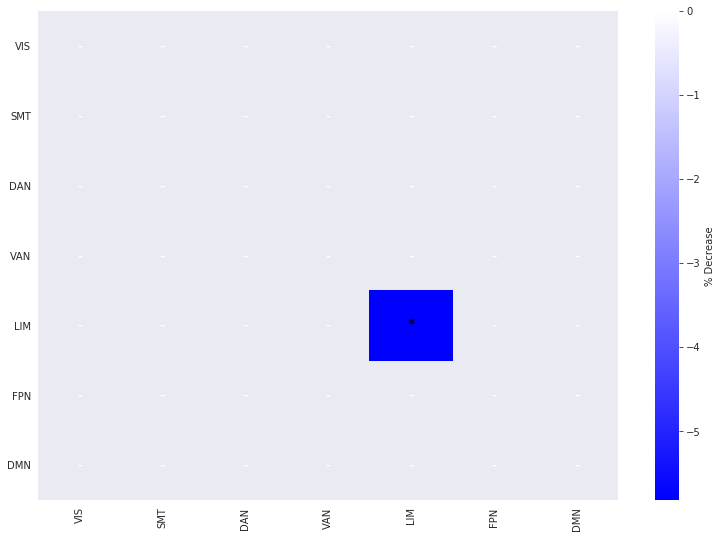

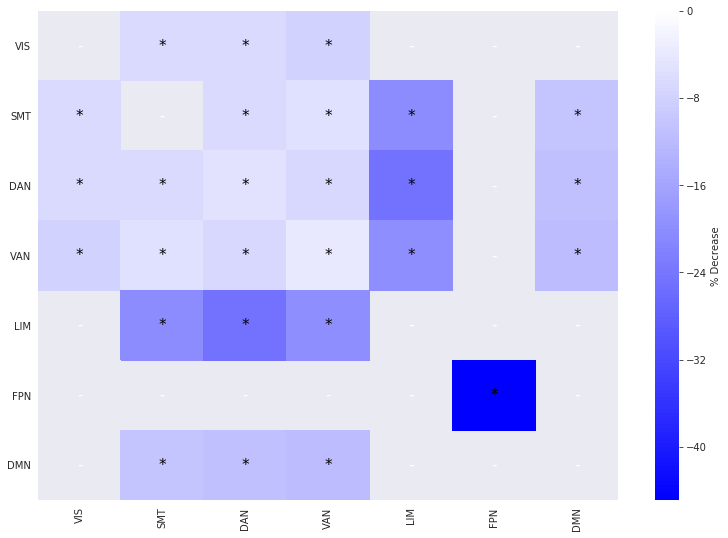

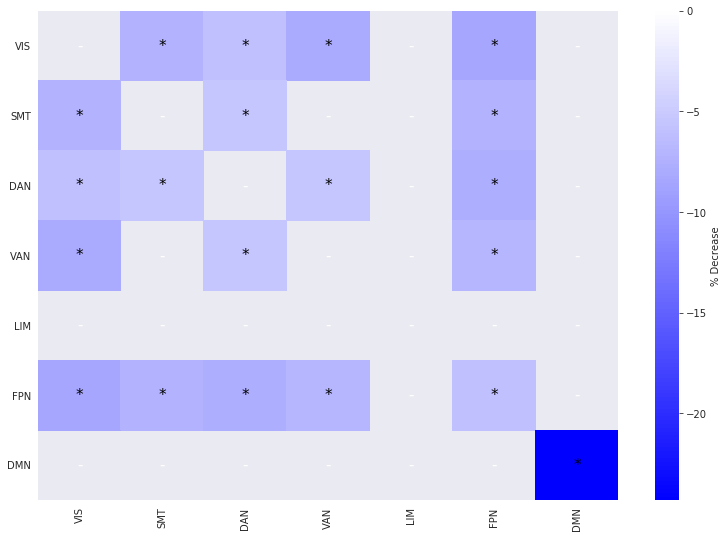

In [125]:
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'], N=256, gamma=1.0)


for i in range(7):
    heatmap_values = percent_change_all_ntwx_all_vals[i,:,:]
    boolean_array = corrected_all_ntwx_sig_tables[i]
    hmap_bool = heatmap_values*boolean_array
    hmap_bool[(hmap_bool == 0.0) | (hmap_bool == -0.0)] = 0.0    
#     cmap = sns.color_palette("RdBu_r")
#     cmap = sns.color_palette("summer")
    
    fig, ax = plt.subplots(figsize=(13,9))
    sns.heatmap(hmap_bool, annot=False, mask=np.logical_not(boolean_array), cmap=cmap, cbar_kws={'label': '% Decrease'}, linecolor='black',linewidth=0.0,center=0)
    for x in range(len(Ntwx_labels)):
        for y in range(len(Ntwx_labels)):
            value = hmap_bool[x, y]
            if value > -90:
                if value < 0.0:
                    ax.text(y + 0.5, x + 0.5, '*', ha='center', va='center', color='black', fontsize=15)
                elif value > 0.0:
                    ax.text(y + 0.5, x + 0.5, '*', ha='center', va='center', color='black', fontsize=15)
                elif value == 0.0:
                    ax.text(y + 0.5, x + 0.5, '-', ha='center', va='center', color='white', fontsize=15)
    ax.set_xticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_xticklabels(Ntwx_labels, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_yticklabels(Ntwx_labels, rotation=0, ha='right')
    plt.show()

In [92]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
    for j in range(7):
        if j!=idx:
            del percent_change_all_ntwx_lesion[j][idx]
    
    percent_drop_means = []
    for k in range(7):
        if k!=idx:
            percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
    percent_drop_stds = []
    for m in range(7):
        if m!=idx:
            percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_drop_means, percent_drop_stds

In [93]:
percent_change_vis_mean, percent_change_vis_std = mean_percent_drops(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt_mean, percent_change_smt_std = mean_percent_drops(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan_mean, percent_change_dan_std = mean_percent_drops(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van_mean, percent_change_van_std = mean_percent_drops(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim_mean, percent_change_lim_std = mean_percent_drops(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn_mean, percent_change_fpn_std = mean_percent_drops(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn_mean, percent_change_dmn_std = mean_percent_drops(dmn_lesion_outer_to_other_ntwx,6)

In [94]:
print(percent_change_vis_mean, '\n')
print('---')
print(percent_change_smt_mean, '\n')
print('---')
print(percent_change_dan_mean, '\n')
print('---')
print(percent_change_van_mean, '\n')
print('---')
print(percent_change_lim_mean, '\n')
print('---')
print(percent_change_fpn_mean, '\n')
print('---')
print(percent_change_dmn_mean, '\n')
print('---')

[-12.73065450250612, -16.72385497715236, -12.926690940169905, -10.582538025166158, -13.294042123262143, -12.41980433423125] 

---
[0.5999794365372135, -1.353026512487479, -0.7164600766430916, -1.1425613124768472, 1.212860077641507, 1.8968760608030582] 

---
[-19.689603784549064, -22.076021437725473, -21.04894872485588, -9.624640879684957, -15.385821297644545, -11.539570921264469] 

---
[-3.675825252645432, -11.098277125669108, -9.483288850325884, -6.561216428607456, -6.047510533796537, -3.578588828216057] 

---
[-0.29640318725207737, 0.5705698083611489, -0.8930246630836619, -0.6937367378508892, -0.22782057691847934, 0.5351530837640016] 

---
[-6.9266654046115725, -8.678082067166022, -10.05857069439698, -9.306984744359504, -13.179919162057002, -7.699797213035807] 

---
[-6.824669847814415, -7.580092080461005, -7.472838482815672, -7.505763339748721, -12.53513962493072, -8.477818636183732] 

---


In [95]:
print(percent_change_vis_std, '\n')
print('---')
print(percent_change_smt_std, '\n')
print('---')
print(percent_change_dan_std, '\n')
print('---')
print(percent_change_van_std, '\n')
print('---')
print(percent_change_lim_std, '\n')
print('---')
print(percent_change_fpn_std, '\n')
print('---')
print(percent_change_dmn_std, '\n')
print('---')

[3.0646899096714457, 4.053382433950038, 2.9558629652692936, 8.594153272707432, 3.343451833376843, 6.1233084573786245] 

---
[1.5756605076083559, 2.6509225631605773, 1.6432591900861706, 3.7618543323680034, 0.5306296494707089, 1.4411388018961426] 

---
[6.103114561915613, 3.371053930025275, 3.2754967024179322, 9.899572972774685, 7.3437858503710745, 8.04951495829005] 

---
[2.8847483896747956, 3.1667721728430673, 3.9203538457157343, 7.8469408990011695, 2.902141766195247, 4.151458652868647] 

---
[0.8665894174762871, 0.4604250284604153, 0.4074402607168404, 0.49438350033347145, 0.590737017710374, 0.9850486073298901] 

---
[3.1560459306989985, 5.471434588305563, 6.790348510838403, 5.262873877237808, 9.431107805302416, 3.4066780791734335] 

---
[2.3257516705960306, 5.270422195836929, 4.268443646170167, 4.991667916958028, 7.154732973467541, 2.789061555772446] 

---


In [96]:
print('LONs <-> LONs')
print(np.mean(percent_change_vis_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_smt_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_dan_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_van_mean[0:3]), '\n')
print('---')

print('LONs <-> HONs')
print(np.mean(percent_change_vis_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_smt_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_dan_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_van_mean[4:6]), '\n')
print('---')


print('==========================================================================')

print('HONs <-> LONs')
print(np.mean(percent_change_lim_mean[0:4]), '\n')
print('---')
print(np.mean(percent_change_fpn_mean[0:4]), '\n')
print('---')
print(np.mean(percent_change_dmn_mean[0:4]), '\n')
print('---')

print('HONs <-> HONs')
print(np.mean(percent_change_lim_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_fpn_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_dmn_mean[4:6]), '\n')
print('---')

LONs <-> LONs
-14.127066806609463 

---
-0.48983571753111904 

---
-20.93819131571014 

---
-8.085797076213474 

---
LONs <-> HONs
-12.856923228746696 

---
1.5548680692222825 

---
-13.462696109454507 

---
-4.813049681006297 

---
HONs <-> LONs
-0.3281486949563699 

---
-8.74257572763352 

---
-7.345840937709953 

---
HONs <-> HONs
0.15366625342276113 

---
-10.439858187546404 

---
-10.506479130557226 

---


In [165]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
#     percent_drop_means = []
#     for k in range(7):
#         if k!=idx:
#             percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
#     percent_drop_stds = []
#     for m in range(7):
#         if m!=idx:
#             percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
#     return percent_drop_means, percent_drop_stds

    return percent_change_all_ntwx_lesion

In [166]:
percent_change_vis = mean_percent_drops(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt = mean_percent_drops(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan = mean_percent_drops(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van = mean_percent_drops(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim = mean_percent_drops(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn = mean_percent_drops(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn = mean_percent_drops(dmn_lesion_outer_to_other_ntwx,6)

In [167]:
print(percent_change_vis[0][0])
print(percent_change_smt[1][1])
print(percent_change_dan[2][2])
print(percent_change_van[3][3])
print(percent_change_lim[4][4])
print(percent_change_fpn[5][5])
print(percent_change_dmn[6][6])

-7.204290046660875
-30.18575912497812
-40.7509831829247
-38.70099387333142
-7.3690447239169625
-11.825371779878797
-7.67392782027167


In [177]:
np.mean([-7.204290046660875,
-30.18575912497812,
-40.7509831829247,
-38.70099387333142])

-29.210506556973776

In [178]:
np.std([-7.204290046660875,
-30.18575912497812,
-40.7509831829247,
-38.70099387333142])

13.308612182776912

In [ ]:
-7.3690447239169625
-11.825371779878797
-7.67392782027167

In [181]:
np.mean([-7.3690447239169625,
-11.825371779878797,
-7.67392782027167])

-8.956114774689143

In [182]:
np.std([-7.3690447239169625,
-11.825371779878797,
-7.67392782027167])

2.0326854563988555

#### Visual

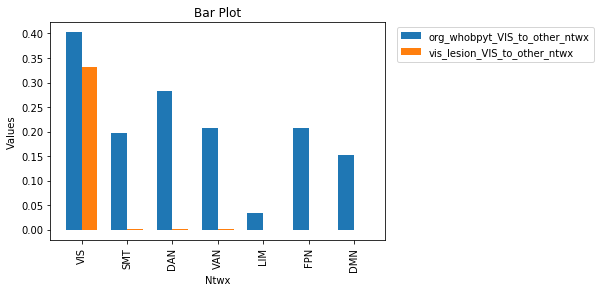

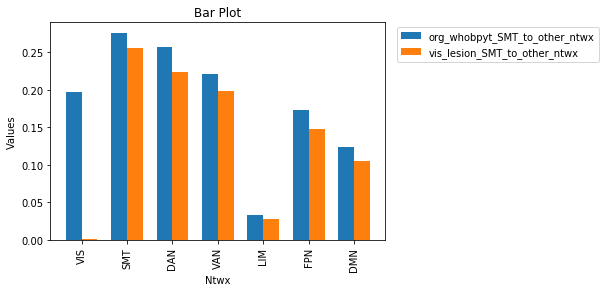

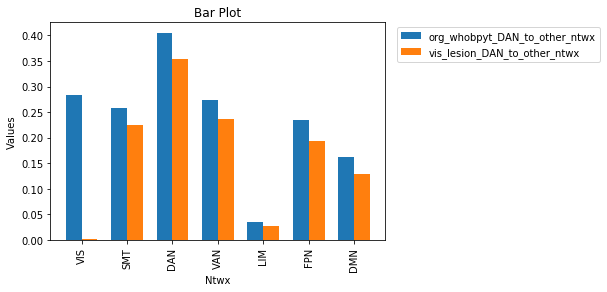

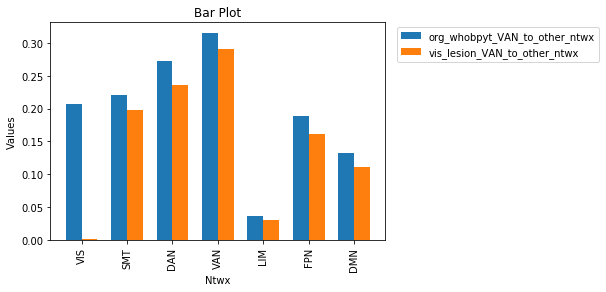

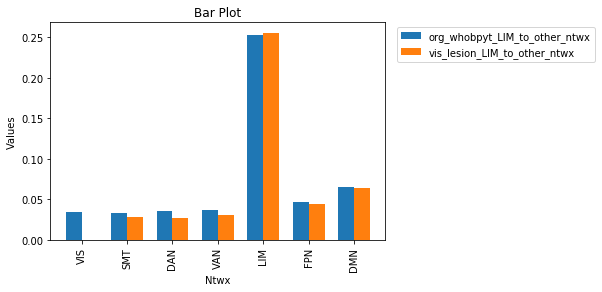

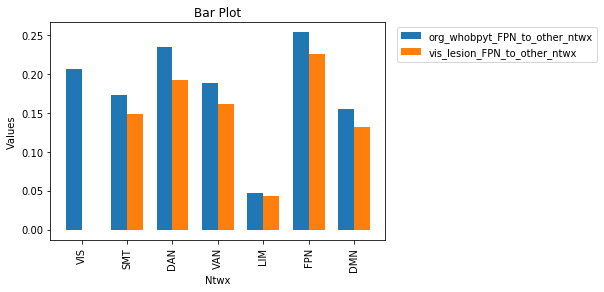

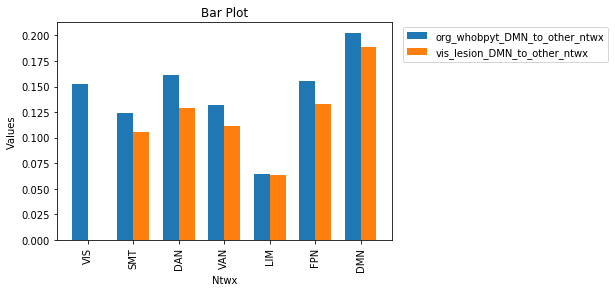

In [99]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

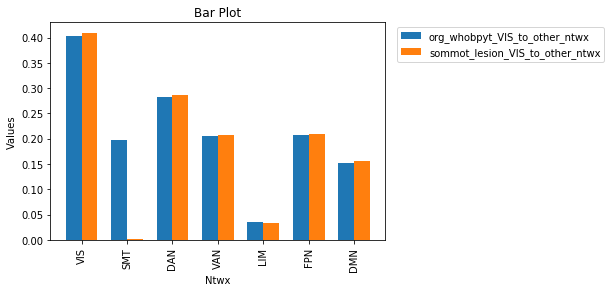

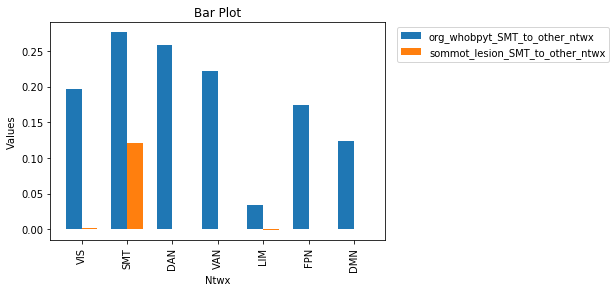

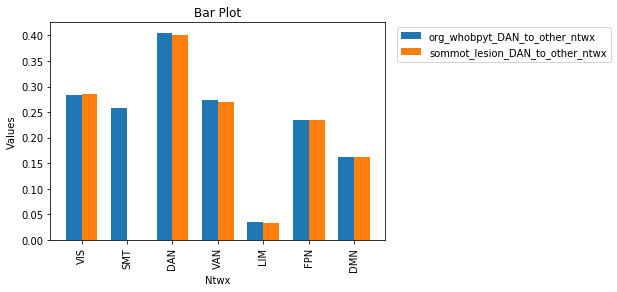

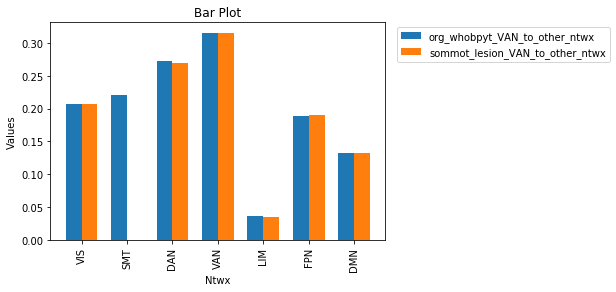

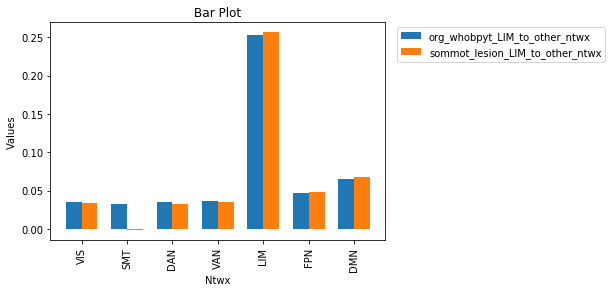

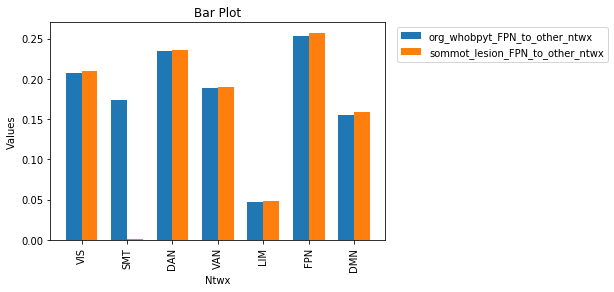

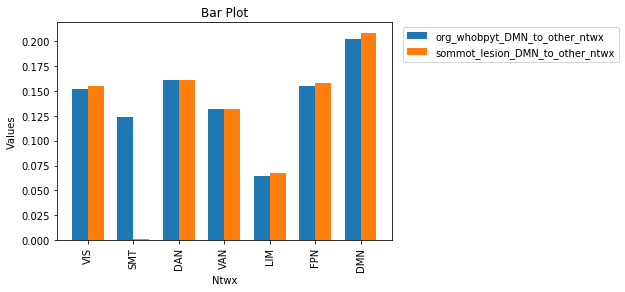

In [100]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    # Displaying the plot
    plt.show()

#### DorsAttn

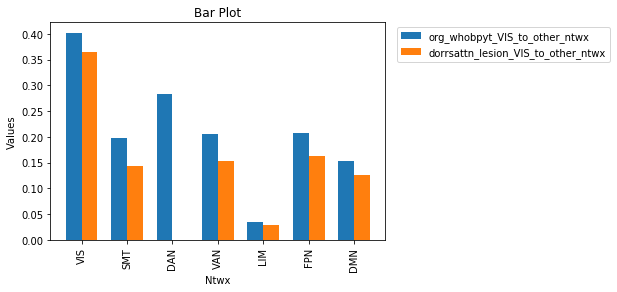

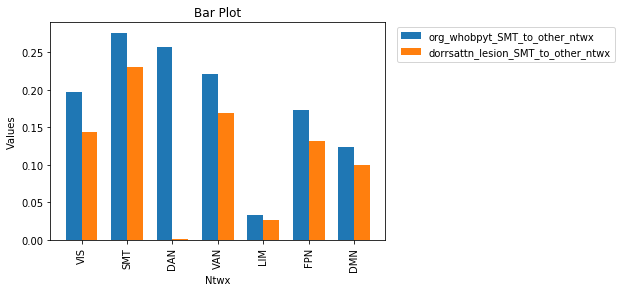

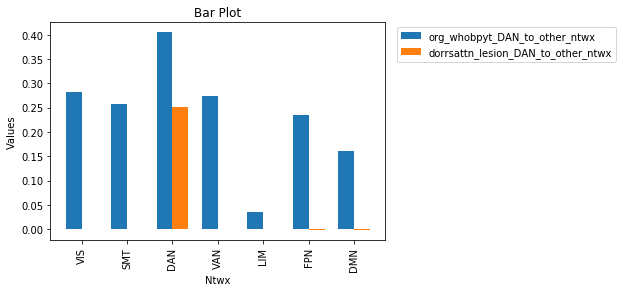

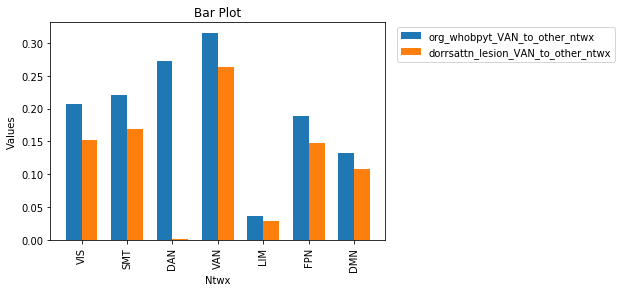

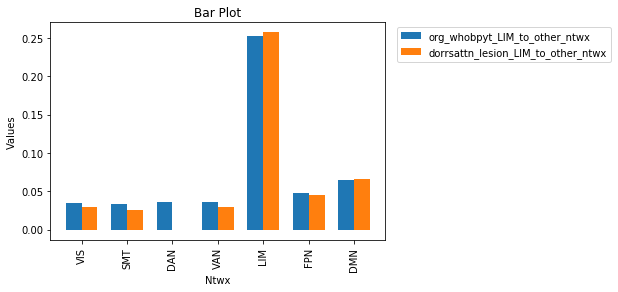

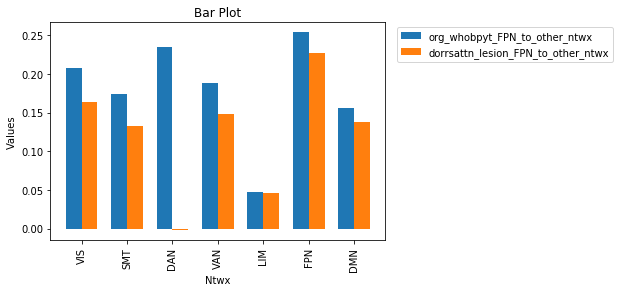

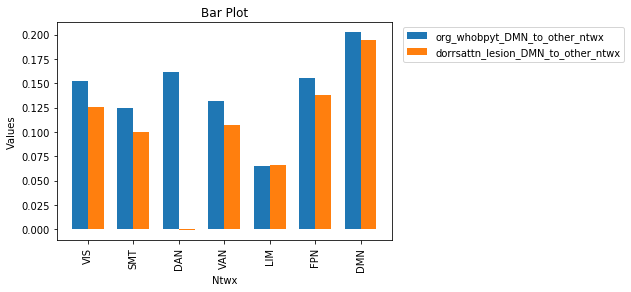

In [101]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

In [64]:
# og_whobpyt_outer_to_other_ntwx

#### VentAttn

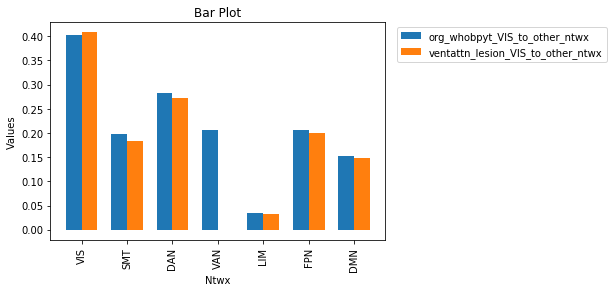

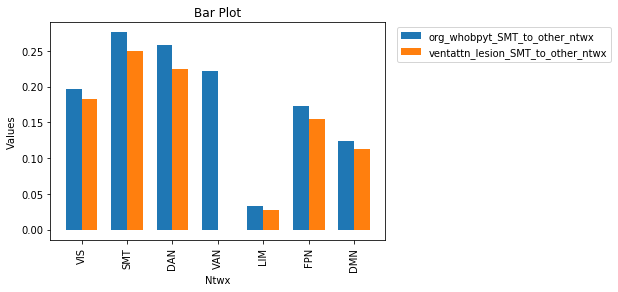

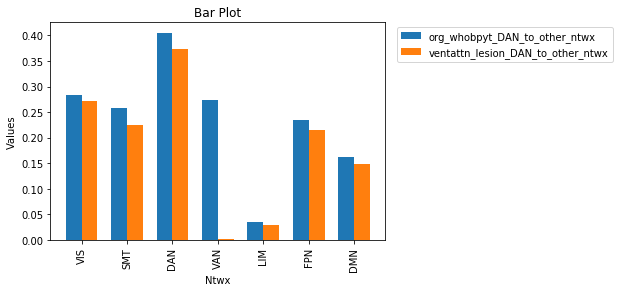

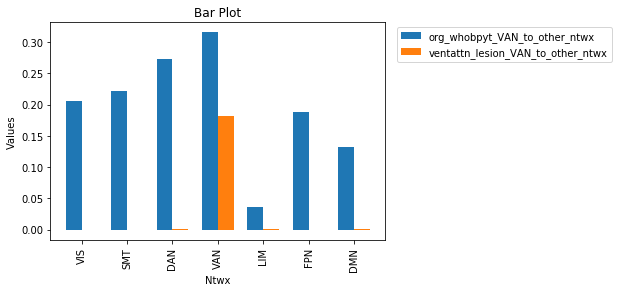

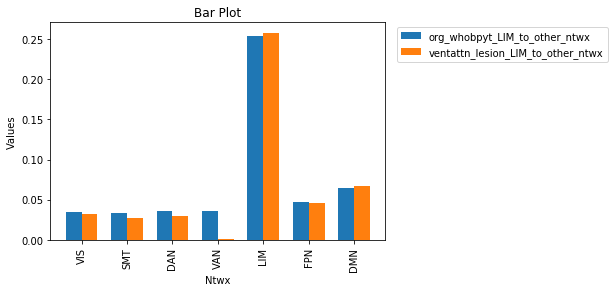

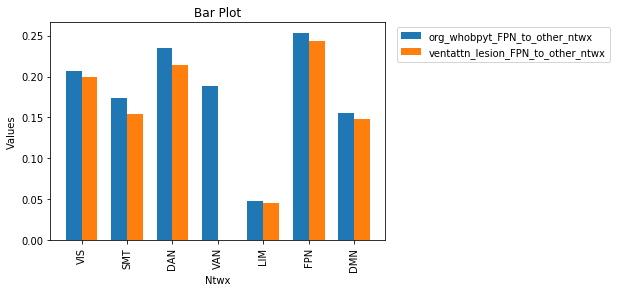

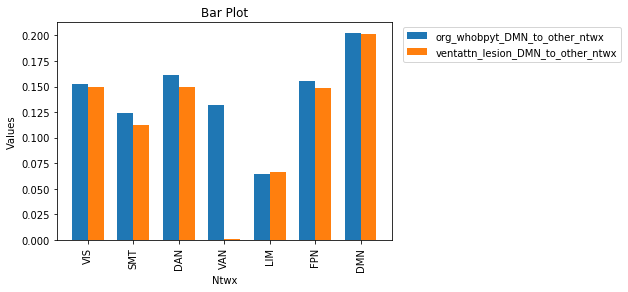

In [102]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

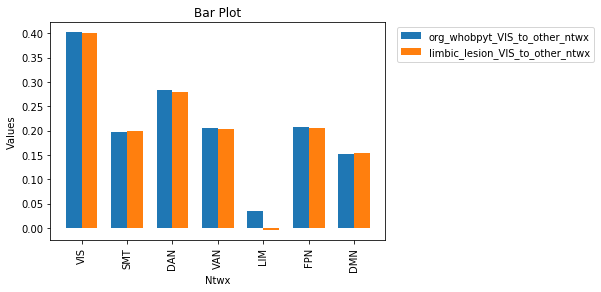

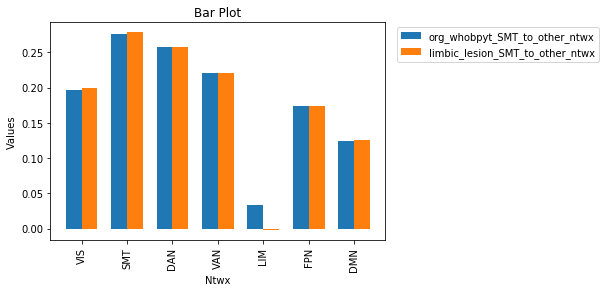

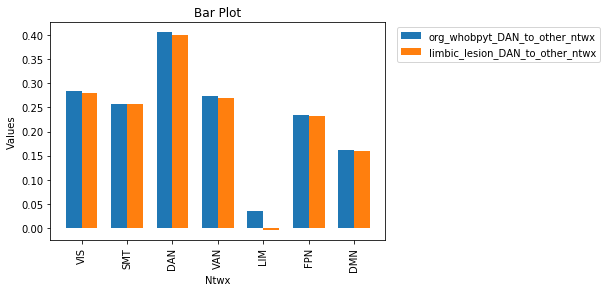

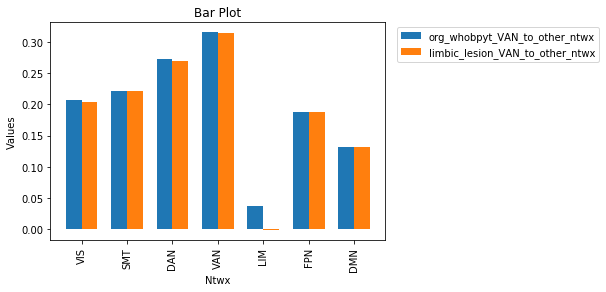

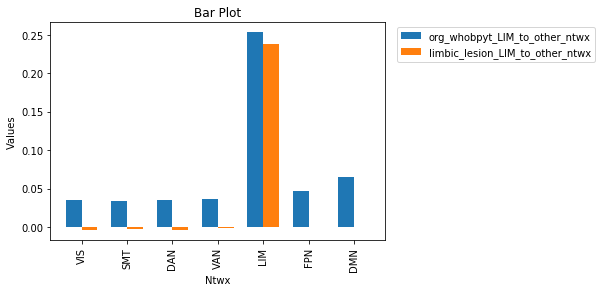

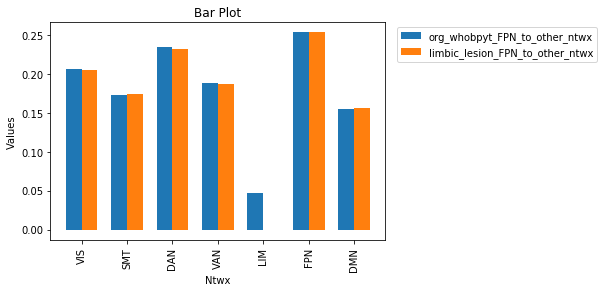

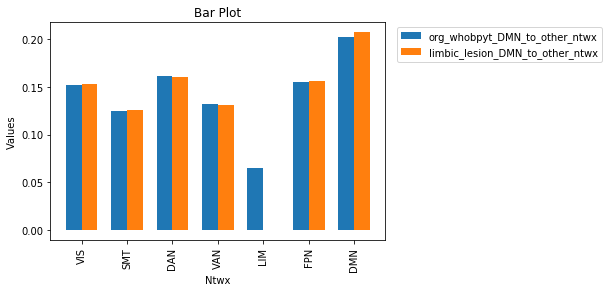

In [103]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

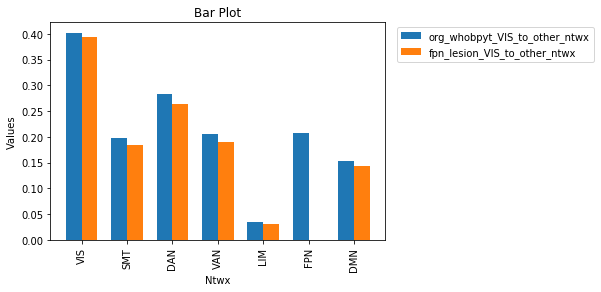

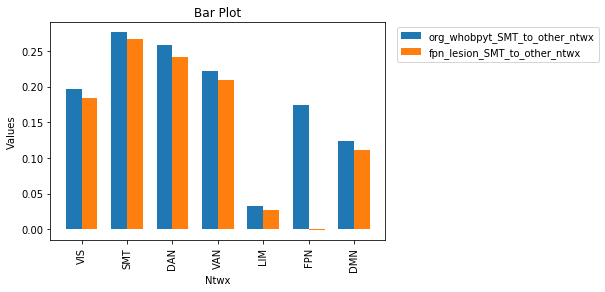

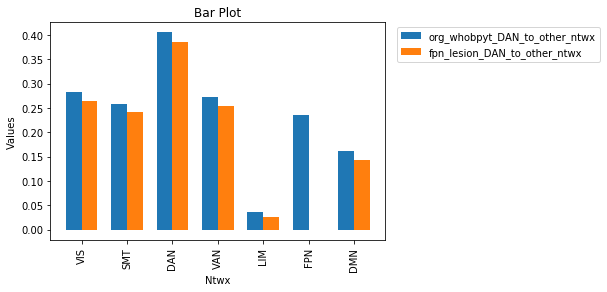

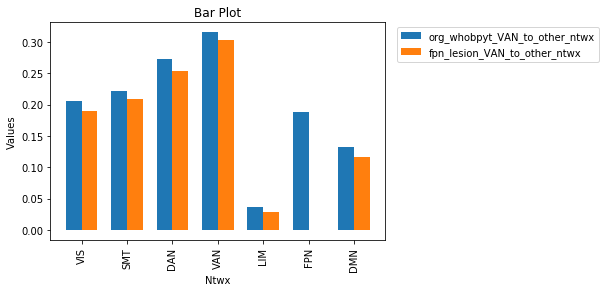

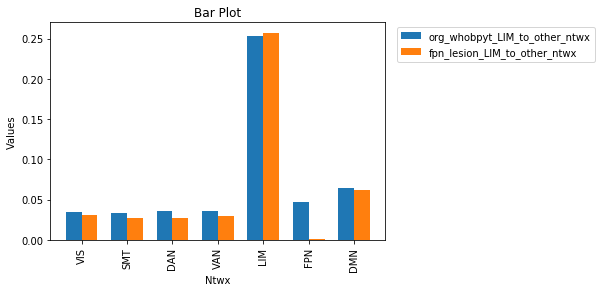

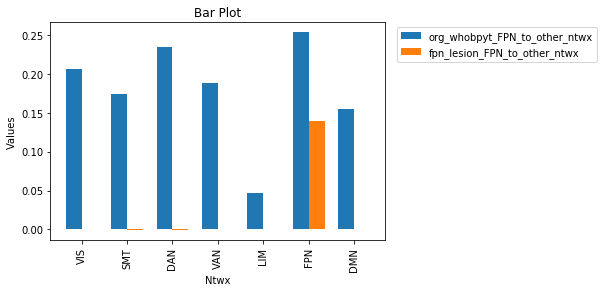

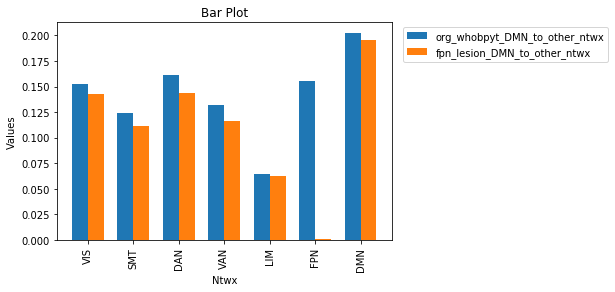

In [104]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

#### DMN

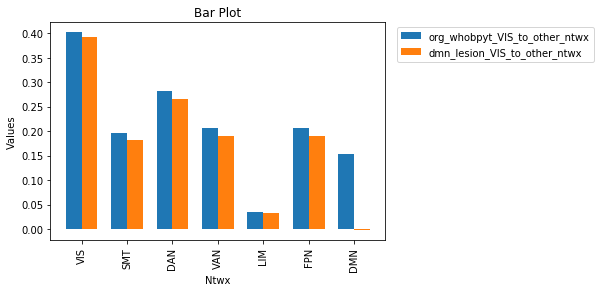

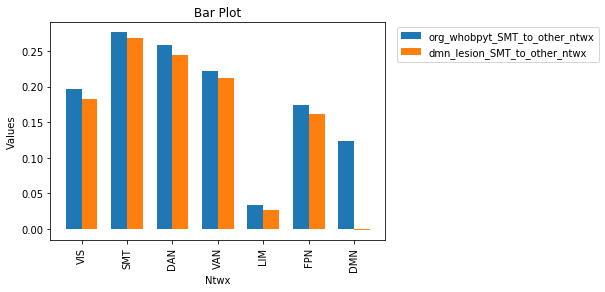

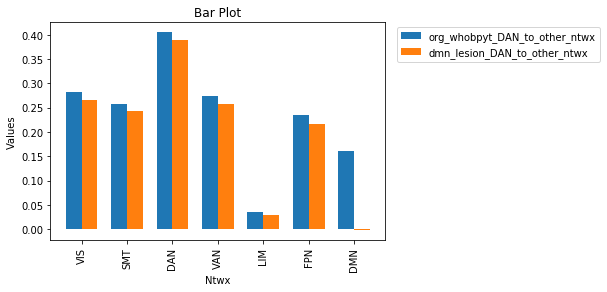

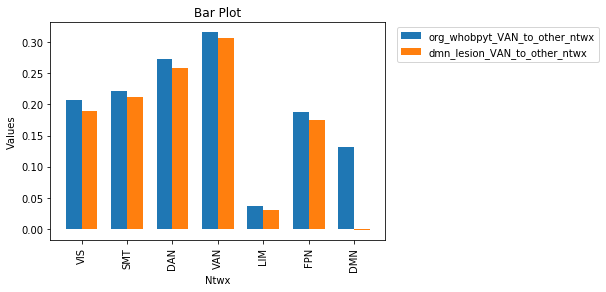

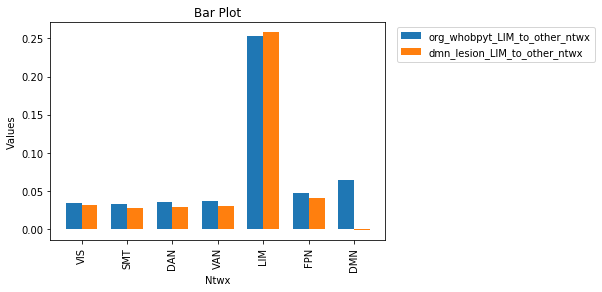

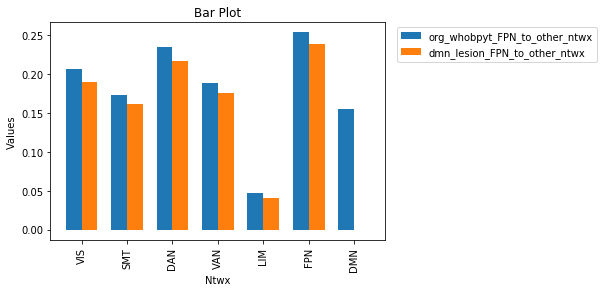

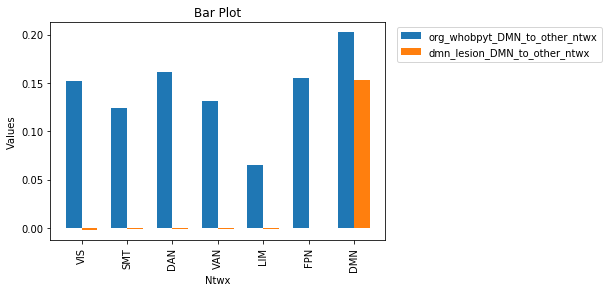

In [105]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)

    # Displaying the plot
    plt.show()

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Stats

In [107]:
Ntwx_labels

['VIS', 'SMT', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

In [109]:
all_ntwx_outer_to_other_ntwx = [vis_lesion_all_subs_outer_to_other_ntwx,
                                smt_lesion_all_subs_outer_to_other_ntwx,
                                dan_lesion_all_subs_outer_to_other_ntwx,
                                van_lesion_all_subs_outer_to_other_ntwx,
                                lim_lesion_all_subs_outer_to_other_ntwx,
                                fpn_lesion_all_subs_outer_to_other_ntwx,
                                dmn_lesion_all_subs_outer_to_other_ntwx]

### `vis` Lesion Stats

In [110]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = vis_lesion_all_subs_outer_to_other_ntwx[i]
    
#     condition_A = [[value for k, value in enumerate(sublist) if k != 0] for sublist in condition_A]
#     condition_B = [[value for m, value in enumerate(sublist) if m != 0] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[ 5.46589347 26.41919836 31.67641193 27.83106832  9.67544245 32.88180387
 28.96943746]
['0.0000001376', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.37586159e-07 7.93012150e-67 1.87367229e-79 2.33182576e-70
 2.23414711e-18 3.72981728e-82 3.95218759e-73]
--------------------- 

SMT to other ntwx stats 

[26.41919836  3.98060714  5.32504169  4.85808616  2.32111034  5.52007816
  5.38695704]
['0.0000000000', '0.0000964511', '0.0000002726', '0.0000024044', '0.0212987167', '0.0000001054', '0.0000002021']
[7.93012150e-67 9.64510564e-05 2.72602457e-07 2.40438344e-06
 2.12987167e-02 1.05422432e-07 2.02138539e-07]
--------------------- 

DAN to other ntwx stats 

[31.67641193  5.32504169  6.00073041  5.64076394  2.9085178   6.44316787
  6.75509288]
['0.0000000000', '0.0000002726', '0.0000000092', '0.0000000579', '0.0040462760', '0.0000000009', '0.0000000002']
[1.87367229e-79 2.72602457e-07 9.20712928e-09 5.78899217e-

### `smt` Lesion Stats

In [111]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = smt_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 1] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 1] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[-1.8796585  -0.74361161 -0.02698851  0.35012937 -0.96333986 -1.22147702]
['0.0616234277', '0.4579929522', '0.9784960820', '0.7266137829', '0.3365520391', '0.2233578203']
[0.06162343 0.45799295 0.97849608 0.72661378 0.33655204 0.22335782]
--------------------- 

SMT to other ntwx stats 

[26.67777981 36.51174955 36.69273263 12.15505431 34.30346875 29.13727732]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.75591691e-67 6.87208624e-90 2.92668447e-90 9.28523647e-26
 2.97069880e-85 1.56311175e-73]
--------------------- 

DAN to other ntwx stats 

[-0.74361161  0.72499932  0.82661887  0.93249863 -0.16877703  0.03856763]
['0.4579929522', '0.4693083702', '0.4094481357', '0.3522145798', '0.8661443124', '0.9692739728']
[0.45799295 0.46930837 0.40944814 0.35221458 0.86614431 0.96927397]
--------------------- 

VAN to other ntwx stats 

[-0.02698851  0.82661887  0.05485189  0.65049544 -0.49344105 -0.19954771]
['0.9784

### `dan` Lesion Stats

In [112]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = dan_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 2] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 2] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[4.13723711 6.39900908 6.29088891 2.01532085 5.84124983 5.29511527]
['0.0000519439', '0.0000000011', '0.0000000020', '0.0452230976', '0.0000000210', '0.0000003147']
[5.19439107e-05 1.10688265e-09 1.98387806e-09 4.52230976e-02
 2.09835548e-08 3.14728236e-07]
--------------------- 

SMT to other ntwx stats 

[6.39900908 5.94629801 6.56306266 3.14365988 6.31973472 5.71976155]
['0.0000000011', '0.0000000122', '0.0000000005', '0.0019250596', '0.0000000017', '0.0000000389']
[1.10688265e-09 1.22160835e-08 4.51400515e-10 1.92505956e-03
 1.69889771e-09 3.89190136e-08]
--------------------- 

DAN to other ntwx stats 

[32.92816    36.42017289 38.33966639 11.13644023 41.43336409 33.44011127]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[2.94564476e-82 1.05971285e-89 1.42710802e-93 1.11241124e-22
 1.65143483e-99 2.20659124e-83]
--------------------- 

VAN to other ntwx stats 

[6.29088891 6.56306266 6.42030491 2.78694851

### `van` Lesion Stats

In [113]:
van_lesion_all_subs_outer_to_other_ntwx

[[[0.28208211296720603,
   -0.004591202138181178,
   0.042454931080099303,
   0.023298396317513535,
   -0.0033236510052771537,
   0.03066668588762373,
   0.02801929298126632],
  [0.286106778153307,
   0.15004195880229348,
   0.16908630263633373,
   0.007240461445138896,
   -0.003271355837904128,
   0.15322517669150043,
   0.12983120177928312],
  [0.36220149050988387,
   0.11893941592454144,
   0.1312148269124775,
   -0.009838869580002626,
   0.04338831142486405,
   0.1465789755009605,
   0.1451805138502417],
  [0.36796510676219835,
   0.22792300203413512,
   0.3159678910524768,
   -0.007615488309977442,
   0.023424620741045885,
   0.17603239511015512,
   0.09693440513364619],
  [0.2614412095582167,
   0.1156152640670905,
   0.23154035383264457,
   -0.02175178758930261,
   0.01950484293150253,
   0.22729397523511474,
   0.1644619422108224],
  [0.22640625779503634,
   0.029635311003516754,
   0.03326998123389745,
   6.475400083081695e-05,
   -0.003565147649770433,
   0.009384865755272254

In [114]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = van_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 3] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 3] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[-1.42188983  3.02580367  2.158308    0.96316859  2.13509618  1.12154516]
['0.1566315201', '0.0028088812', '0.0321074424', '0.3366377521', '0.0339820941', '0.2634142075']
[0.15663152 0.00280888 0.03210744 0.33663775 0.03398209 0.26341421]
--------------------- 

SMT to other ntwx stats 

[3.02580367 4.20943179 4.74072181 2.55944794 4.42585891 3.35305958]
['0.0028088812', '0.0000388186', '0.0000040634', '0.0112301419', '0.0000158532', '0.0009575284']
[2.80888120e-03 3.88185945e-05 4.06338108e-06 1.12301419e-02
 1.58531772e-05 9.57528381e-04]
--------------------- 

DAN to other ntwx stats 

[2.158308   4.74072181 4.26029401 2.08969901 4.13737873 3.12194124]
['0.0321074424', '0.0000040634', '0.0000315459', '0.0379221681', '0.0000519144', '0.0020655821']
[3.21074424e-02 4.06338108e-06 3.15459053e-05 3.79221681e-02
 5.19144318e-05 2.06558215e-03]
--------------------- 

VAN to other ntwx stats 

[28.31766676 36.18356646 37.75131262 11.89687492 41.36519547 31.79502

### `lim` Lesion Stats

In [115]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = lim_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 4] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 4] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[ 0.23757821 -0.67318414  0.77220958  1.08851985  0.64446766 -0.38896544]
['0.8124539028', '0.5016151222', '0.4409110366', '0.2776888279', '0.5200181433', '0.6977196809']
[0.8124539  0.50161512 0.44091104 0.27768883 0.52001814 0.69771968]
--------------------- 

SMT to other ntwx stats 

[-0.67318414 -0.87700312  0.09793683 -0.02086347 -0.44655991 -0.60319689]
['0.5016151222', '0.3815477734', '0.9220815255', '0.9833755735', '0.6556808655', '0.5470680406']
[0.50161512 0.38154777 0.92208153 0.98337557 0.65568087 0.54706804]
--------------------- 

DAN to other ntwx stats 

[0.77220958 0.09793683 1.38825981 1.09664167 0.81358963 0.44567686]
['0.4409110366', '0.9220815255', '0.1666178947', '0.2741300377', '0.4168573804', '0.6563176104']
[0.44091104 0.92208153 0.16661789 0.27413004 0.41685738 0.65631761]
--------------------- 

VAN to other ntwx stats 

[ 1.08851985 -0.02086347  1.09664167  0.61822412  0.45850262  0.2313517 ]
['0.2776888279', '0.9833755735', '0.274

### `fpn` Lesion Stats

In [116]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = fpn_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 5] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 5] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[1.31107228 2.68056211 2.93455348 3.20568941 1.5633976  2.15827298]
['0.1913518141', '0.0079693148', '0.0037348988', '0.0015709493', '0.1195559612', '0.0321102025']
[0.19135181 0.00796931 0.0037349  0.00157095 0.11955596 0.0321102 ]
--------------------- 

SMT to other ntwx stats 

[2.68056211 2.28266641 3.36312085 2.88260483 2.96205354 3.81302568]
['0.0079693148', '0.0235124545', '0.0009251313', '0.0043795927', '0.0034299676', '0.0001833018']
[0.00796931 0.02351245 0.00092513 0.00437959 0.00342997 0.0001833 ]
--------------------- 

DAN to other ntwx stats 

[2.93455348 3.36312085 3.10746028 3.55117755 3.25007887 3.93673696]
['0.0037348988', '0.0009251313', '0.0021644811', '0.0004792127', '0.0013557430', '0.0001143361']
[0.0037349  0.00092513 0.00216448 0.00047921 0.00135574 0.00011434]
--------------------- 

VAN to other ntwx stats 

[3.20568941 2.88260483 3.55117755 2.93198766 2.98901437 4.24160657]
['0.0015709493', '0.0043795927', '0.0004792127', '0.00376

### `dmn` Lesion Stats

In [117]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = dmn_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 6] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 6] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

VIS to other ntwx stats 

[1.49268072 2.88280172 2.76504416 3.31962797 1.22975024 3.40603942]
['0.1371124645', '0.0043769683', '0.0062294810', '0.0010729403', '0.2202498712', '0.0007980935']
[0.13711246 0.00437697 0.00622948 0.00107294 0.22024987 0.00079809]
--------------------- 

SMT to other ntwx stats 

[2.88280172 1.74994279 2.71390327 2.05899206 2.44116436 2.95310438]
['0.0043769683', '0.0816772973', '0.0072361077', '0.0408039297', '0.0155188101', '0.0035265976']
[0.00437697 0.0816773  0.00723611 0.04080393 0.01551881 0.0035266 ]
--------------------- 

DAN to other ntwx stats 

[2.76504416 2.71390327 2.47908839 2.75457175 2.01960882 3.41215153]
['0.0062294810', '0.0072361077', '0.0140074899', '0.0064246279', '0.0447719038', '0.0007813894']
[0.00622948 0.00723611 0.01400749 0.00642463 0.0447719  0.00078139]
--------------------- 

VAN to other ntwx stats 

[3.31962797 2.05899206 2.75457175 1.86006009 2.44410721 2.96047947]
['0.0010729403', '0.0408039297', '0.0064246279', '0.06436